In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions

In [2]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0                             #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck 
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-(x0*γ*Δt)+(sqrt(2*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 1 method)

In [3]:
function eigen2(n::Int64,K::Array{Float64,1},T::Array{Float64,1},Δs::Float64) 
    R=diagm(0 =>ones(3)) #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n            #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*Δs,-1 => -[K[i],T[i]]*Δs)+(0.5*diagm(1 => [K[i],T[i]]*Δs,-1 => -[K[i],T[i]]*Δs)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R) #Obtenemos el eigenvalor y eigenvector
end

eigen2 (generic function with 1 method)

In [4]:
function lam_eigenvals(γ::Float64,x0::Float64,Δt::Float64,t::AbstractArray,Δs::Float64,tiradas::Int64)
    λ=Vector{Complex{Float64}}(undef,3*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas #Un for con la cantidad de tiradas
        K=OUH(x0,γ,t,Δt) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        T=OUH(x0,γ,t,Δt) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),K,T,Δs).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[3*i-2]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-1]=a[2] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-0]=a[3] #Reescribirmos la basura con los eigenvalores
    end
    return λ
end

lam_eigenvals (generic function with 1 method)

In [5]:
function lam_eigenvals_R(λ::Array{Complex{Float64},1})
    λr=Float64[]
    for i=1:length(λ)
        if imag(λ[i]) == 0
            push!(λr,λ[i])
        end
    end
    return λr
end

lam_eigenvals_R (generic function with 1 method)

In [6]:
function lam_eigenvals_C(λ::Array{Complex{Float64},1})
    λr=Complex{Float64}[]
    for i=1:length(λ)
        if imag(λ[i]) != 0
            push!(λr,λ[i])
        end
    end
    return λr
end

lam_eigenvals_C (generic function with 1 method)

In [7]:
function Mat(n::Int64,K::Array{Float64,1},T::Array{Float64,1},Δs::Float64) 
    R=diagm(0 =>ones(3))
    for i=1:n
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*Δs,-1 => -[K[i],T[i]]*Δs)+(0.5*diagm(1 => [K[i],T[i]]*Δs,-1 => -[K[i],T[i]]*Δs)^2))*R
    end
    R
end

Mat (generic function with 1 method)

In [8]:
function Trayectoria(γ::Float64, x0::Float64,Δt::Float64,Δs::Float64,t::AbstractArray)
    K=OUH(x0,γ,t,Δt);
    T=OUH(x0,γ,t,Δt)
    #T=ones(2001)*5
    #K=ones(2001)*5

    T_v0=(eigen2(2,K,T,Δs).vectors)[:,1]      #Es el vector tangente inicial
    N_v0=(eigen2(2,K,T,Δs).vectors)[:,2]*im   #Es el vector tangente inicial
    B_v0=(eigen2(2,K,T,Δs).vectors)[:,3]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    N_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    B_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    for i=1:length(t)                 #For que dura todos los pasos de tiempo
        T_v1=Mat(i,K,T,Δs)*T_v0      #Genera todos los vecotres tangentes a partir del inicial
        N_v1=Mat(i,K,T,Δs)*N_v0      #Genera todos los vecotres tangentes a partir del inicial
        B_v1=Mat(i,K,T,Δs)*B_v0      #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))    #Coloca los vectores tangentes en una lista
        push!(N_v,real(N_v1))    #Coloca los vectores tangentes en una lista
        push!(B_v,real(B_v1))    #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    N_v=transpose(hcat(N_v...))     #Transforma N en algo mejor
    B_v=transpose(hcat(B_v...))     #Transforma B en algo mejor
    ##########################################
    Tx=T_v[:,1]
    Ty=T_v[:,2]
    Tz=T_v[:,3]
    ##########################################
    rx=Float64[]
    ry=Float64[]
    rz=Float64[]
    r1x=0.0
    r1y=0.0
    r1z=0.0
    for i=1:length(t)
        r1x=Tx[i]*Δs+r1x
        r1y=Ty[i]*Δs+r1y
        r1z=Tz[i]*Δs+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    return plot(rx,ry,rz,legend=false,lw=1)
end
function Trayectoria!(γ::Float64, x0::Float64,Δt::Float64,Δs::Float64,t::AbstractArray)
    K=OUH(x0,γ,t,Δt); #Hace el proceso de Ornstein–Uhlenbeck
    T=OUH(x0,γ,t,Δt) #Hace el proceso de Ornstein–Uhlenbeck
    #T=ones(2001)*5
    #K=ones(2001)*5

    T_v0=(eigen2(2,K,T,Δs).vectors)[:,1]      #Es el vector tangente inicial
    N_v0=(eigen2(2,K,T,Δs).vectors)[:,2]*im   #Es el vector tangente inicial
    B_v0=(eigen2(2,K,T,Δs).vectors)[:,3]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]      #Lista vacia para todos los vectores tangentes
    N_v=Array{Float64,1}[]      #Lista vacia para todos los vectores tangentes
    B_v=Array{Float64,1}[]      #Lista vacia para todos los vectores tangentes
    for i=1:length(t)             #For que dura todos los pasos de tiempo
        T_v1=Mat(i,K,T,Δs)*T_v0 #Genera todos los vecotres tangentes a partir del inicial
        N_v1=Mat(i,K,T,Δs)*N_v0 #Genera todos los vecotres tangentes a partir del inicial
        B_v1=Mat(i,K,T,Δs)*B_v0 #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))         #Coloca los vectores tangentes en una lista
        push!(N_v,real(N_v1))         #Coloca los vectores tangentes en una lista
        push!(B_v,real(B_v1))         #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    N_v=transpose(hcat(N_v...))     #Transforma N en algo mejor
    B_v=transpose(hcat(B_v...))     #Transforma B en algo mejor
    ##########################################
    Tx=T_v[:,1]                   #Solo selecciona las componentes x de la lista de las tangentes
    Ty=T_v[:,2]                   #Solo selecciona las componentes Y de la lista de las tangentes
    Tz=T_v[:,3]                   #Solo selecciona las componentes Z de la lista de las tangentes
    ##########################################
    rx=Float64[]      #Lista vacia para la trayectoria en x
    ry=Float64[]      #Lista vacia para la trayectoria en y
    rz=Float64[]      #Lista vacia para la trayectoria en z
    r1x=0.0            #El punto inicial para la trayectoria en x
    r1y=0.0            #El punto inicial para la trayectoria en y
    r1z=0.0            #El punto inicial para la trayectoria en z
    for i=1:length(t)        #Integral de rieman seccion por seccion
        r1x=Tx[i]*Δs+r1x
        r1y=Ty[i]*Δs+r1y
        r1z=Tz[i]*Δs+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    return plot!(rx,ry,rz,legend=false,lw=1)
end

Trayectoria! (generic function with 1 method)

In [9]:
γ=1.0
tiradas=1000
x0=0.0
Δt=0.001
N=5.0
t=0:Δt:N
Δs=Δt
step=50 #Para animar
length(1:step:length(t))


101

In [10]:
@time λ=lam_eigenvals(γ,x0,Δt,t,Δs,tiradas);

 34.398522 seconds (322.41 M allocations: 15.403 GiB, 6.54% gc time)


In [11]:
histogram(lam_eigenvals_R(λ),bins=60);

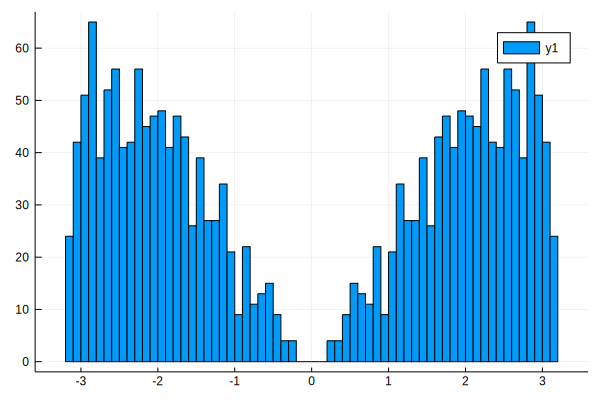

In [12]:
histogram(angle.(lam_eigenvals_C(λ)),bins=60)

In [13]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)")
Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Norma")
plot(Q1,Q2,Q3,Q4,layout=l);
#savefig("Eigenvalores_Completo_3D_x0=$(x0).png")

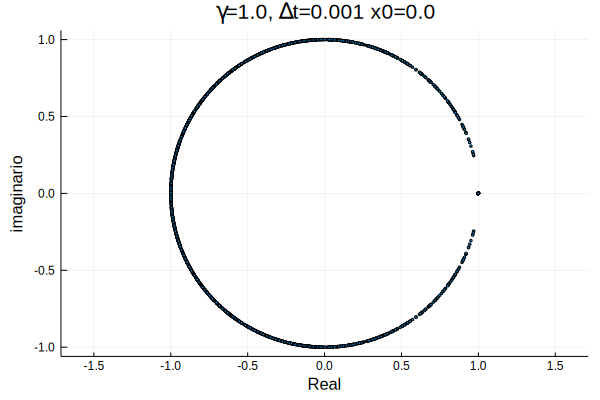

In [14]:
scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)")
#savefig("Eigenvalores_3D_x0=$(x0).png")

In [15]:
histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Norma");
#savefig("Eigenvalores_Norma_3D_x0=$(x0).png")

In [16]:
histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase");
#savefig("Eigenvalores_Fases_3D_x0=$(x0).png")

1446.537125 seconds (15.62 G allocations: 746.783 GiB, 6.21% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\SEB\Documents\JULIA\Tesis\Animacion_Prueba_3D_x0=0.0.gif
└ @ Plots C:\Users\SEB\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\SEB\\Documents\\JULIA\\Tesis\\Animacion_Prueba_3D_x0=0.0.gif")
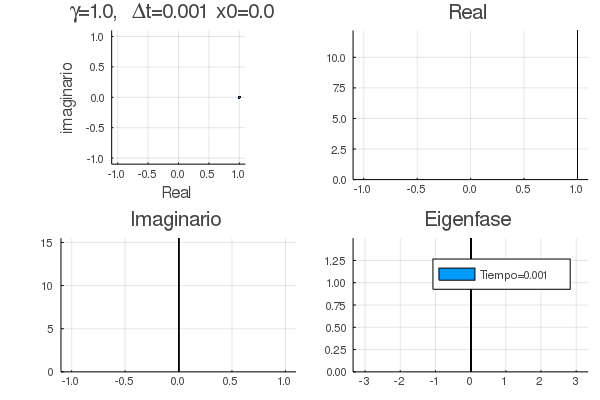

In [19]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals(γ,x0,Δt,t[1:j],Δs,tiradas);
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)",xlims=(-1.1,1.1),ylims=(-1.1,1.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_x0=$(x0).gif", fps=120)
end

1918.976561 seconds (15.62 G allocations: 746.717 GiB, 6.21% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\SEB\Documents\JULIA\Tesis\Animacion_Prueba_3D_x0=0.0_no_reals.gif
└ @ Plots C:\Users\SEB\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\SEB\\Documents\\JULIA\\Tesis\\Animacion_Prueba_3D_x0=0.0_no_reals.gif")
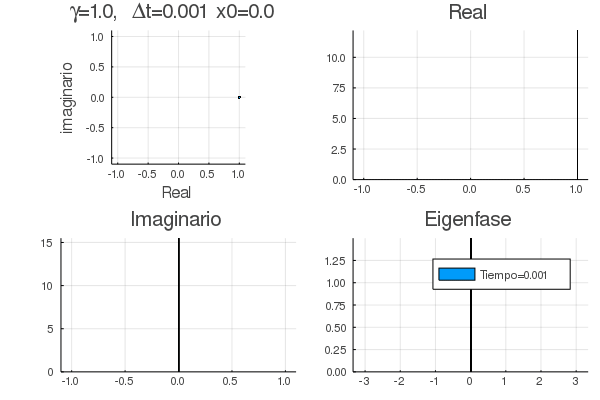

In [18]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals_C(lam_eigenvals(γ,x0,Δt,t[1:j],Δs,tiradas));
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)",xlims=(-1.1,1.1),ylims=(-1.1,1.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_x0=$(x0)_no_reals.gif", fps=120)
end

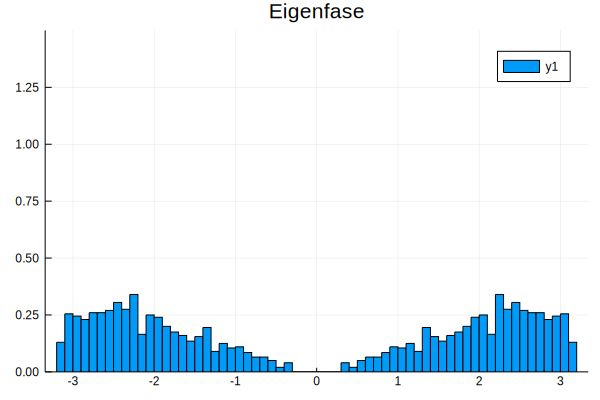

1097.346496 seconds (9.46 G allocations: 449.567 GiB, 6.50% gc time)


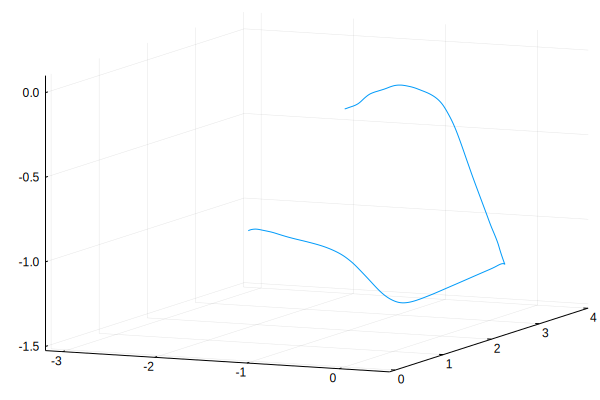

In [14]:
@time Trayectoria(γ,x0,Δt,Δs,t)